In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

In [2]:
%ls data/

sample_submission.csv      test.csv      train.csv
sample_submission.csv.zip  test.csv.zip  train.csv.zip


In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

# Description

According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.

In [4]:
print(train.shape)
print(test.shape)

(4459, 4993)
(49342, 4992)


In [5]:
train.head()

ID      target  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  \
0  000d6aaf2  38000000.0        0.0          0        0.0          0   
1  000fbd867    600000.0        0.0          0        0.0          0   
2  0027d6b71  10000000.0        0.0          0        0.0          0   
3  0028cbf45   2000000.0        0.0          0        0.0          0   
4  002a68644  14400000.0        0.0          0        0.0          0   

   2f0771a37  30347e683  d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8  \
0          0          0          0          0        0.0        0.0   
1          0          0          0          0  2200000.0        0.0   
2          0          0          0          0        0.0        0.0   
3          0          0          0          0        0.0        0.0   
4          0          0          0          0  2000000.0        0.0   

   11d86fa6a  77c9823f2  8d6c2a0b2  4681de4fd  adf119b9a  cff75dd09  \
0        0.0          0          0          0          0        0.0   
1        0.0          0          0          0          0        0.0   
2        0.0          0          0          0          0        0.0   
3        0.0          0          0          0          0        0.0   
4        0.0          0          0          0          0        0.0   

   96f83a237  b8a716ebf  6c7a4567c  4fcfd2b4d  f3b9c0b95  71cebf11c  \
0          0        0.0          0          0        0.0          0   
1          0        0.0          0          0        0.0          0   
2          0        0.0          0          0        0.0          0   
3          0        0.0          0          0        0.0          0   
4          0        0.0          0          0        0.0          0   

   d966ac62c  68b647452  c88d108c9  ff7b471cd  d5308d8bc  0d866c3d7  \
0          0        0.0          0          0          0        0.0   
1          0        0.0          0          0          0        0.0   
2          0        0.0          0          0          0        0.0   
3          0        0.0          0          0          0        0.0   
4          0        0.0          0          0          0        0.0   

   bc3f77679  bd8f989f1  0eff5bf95  22ed6dba3  92b13ebba  c330f1a67  \
0          0        0.0          0        0.0        0.0          0   
1          0        0.0          0        0.0        0.0          0   
2          0        0.0          0        0.0        0.0          0   
3          0        0.0          0        0.0        0.0          0   
4          0        0.0          0        0.0        0.0          0   

   233c7c17c  2cb4d123e  eeac16933  87ffda550  822e49b95  316b978cd  \
0        0.0          0          0  1300000.0        0.0          0   
1        0.0          0          0        0.0        0.0          0   
2        0.0          0          0        0.0        0.0          0   
3        0.0          0          0        0.0        0.0          0   
4        0.0          0          0        0.0        0.0          0   

   d04e16aed  5d5c5ce6d  ec863cb52  11ad148bd  ea18d720e  408d86ce9  \
0        0.0          0          0        0.0        0.0        0.0   
1        0.0          0          0        0.0        0.0        0.0   
2        0.0          0          0        0.0        0.0        0.0   
3        0.0          0          0        0.0        0.0        0.0   
4        0.0          0          0        0.0        0.0        0.0   

   69d8b4020  b0868a049  80b14398e  ecdef52b2  c36bcacc5  151d318cd  \
0          0          0        0.0        0.0          0          0   
1          0          0        0.0        0.0          0          0   
2          0          0        0.0        0.0          0          0   
3          0          0        0.0        0.0          0          0   
4          0          0        0.0        0.0          0          0   

   ab0cddb90  2d6bd8275   dfdf4b580  c87722678  a8c320153  7df8788e8  \
0          0        0.0         0.0          0          0          0   
1          0     

Looks like we cant understand what the data is about just by seeing the columns and their values.

Lets see how many can be categorical variables

In [6]:
categorical_list = []
for col in train.columns:
    if train[col].nunique() <= 5:
        categorical_list.append(col)

In [7]:
len(categorical_list)

1039

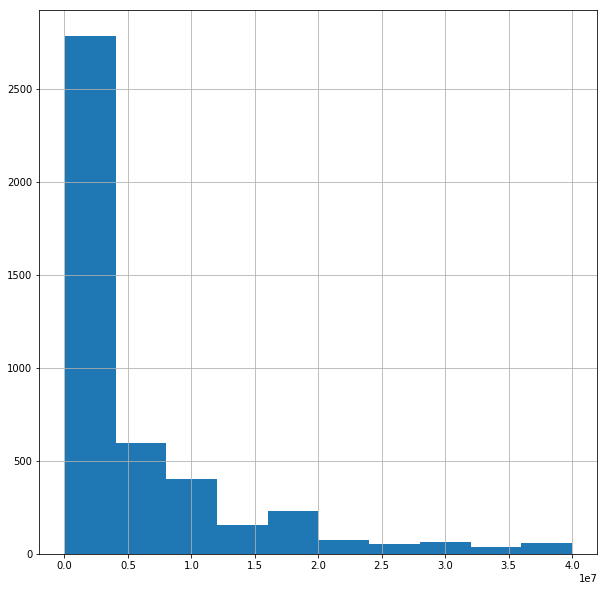

In [8]:
train['target'].hist(figsize=(10, 10))

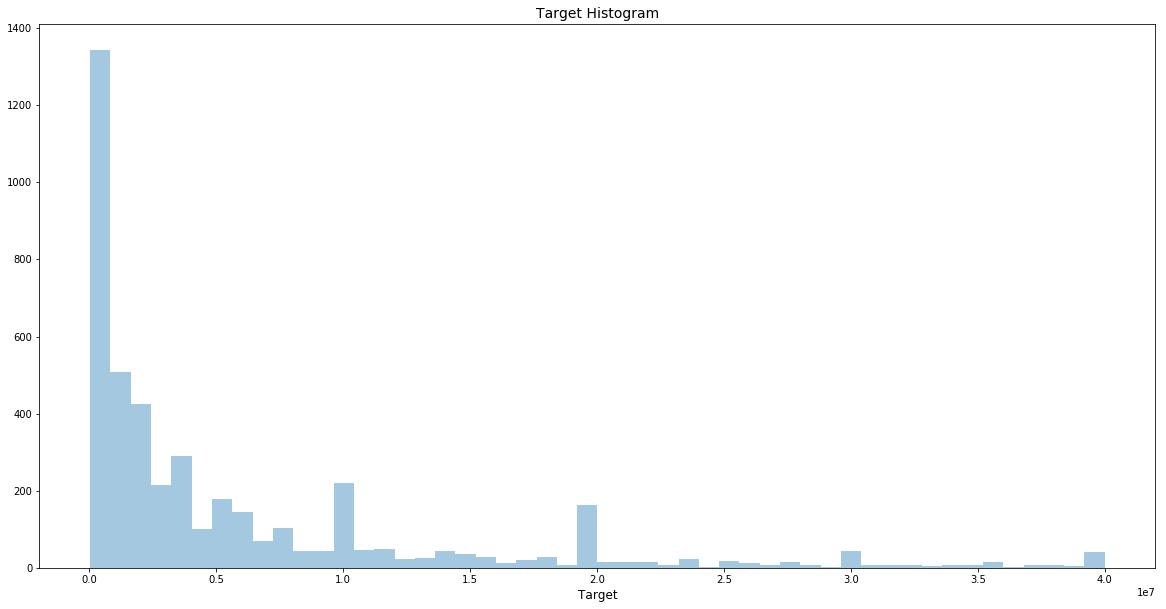

In [9]:
plt.figure(figsize=(20,10))
sns.distplot(train["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

### Lets see the distribution on log scale

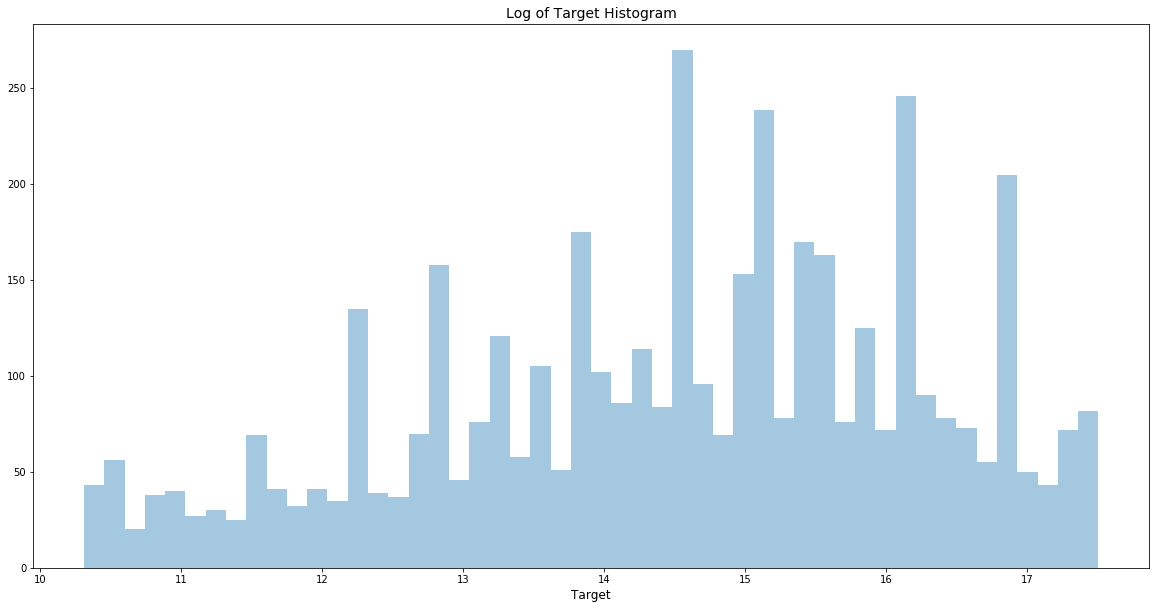

In [10]:
plt.figure(figsize=(20,10))
sns.distplot( np.log1p(train["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

#### Maybe taking log of the target and then expanding it later would help

### Check the columns for constant values

In [11]:
constant_list = []
for col in train.columns:
    if train[col].nunique() <= 1:
        constant_list.append(col)

In [12]:
len(constant_list)

256

#### It is better to drop constants as they don't help in training

In [13]:
train.drop(constant_list, inplace=True, axis=1)

In [14]:
train.shape

(4459, 4737)

#### same must be dropped from test too

In [15]:
test.drop(constant_list, inplace=True, axis=1)

In [16]:
test.shape

(49342, 4736)

### Find the columns that are highly correlated

In [17]:
corr = train.corr()

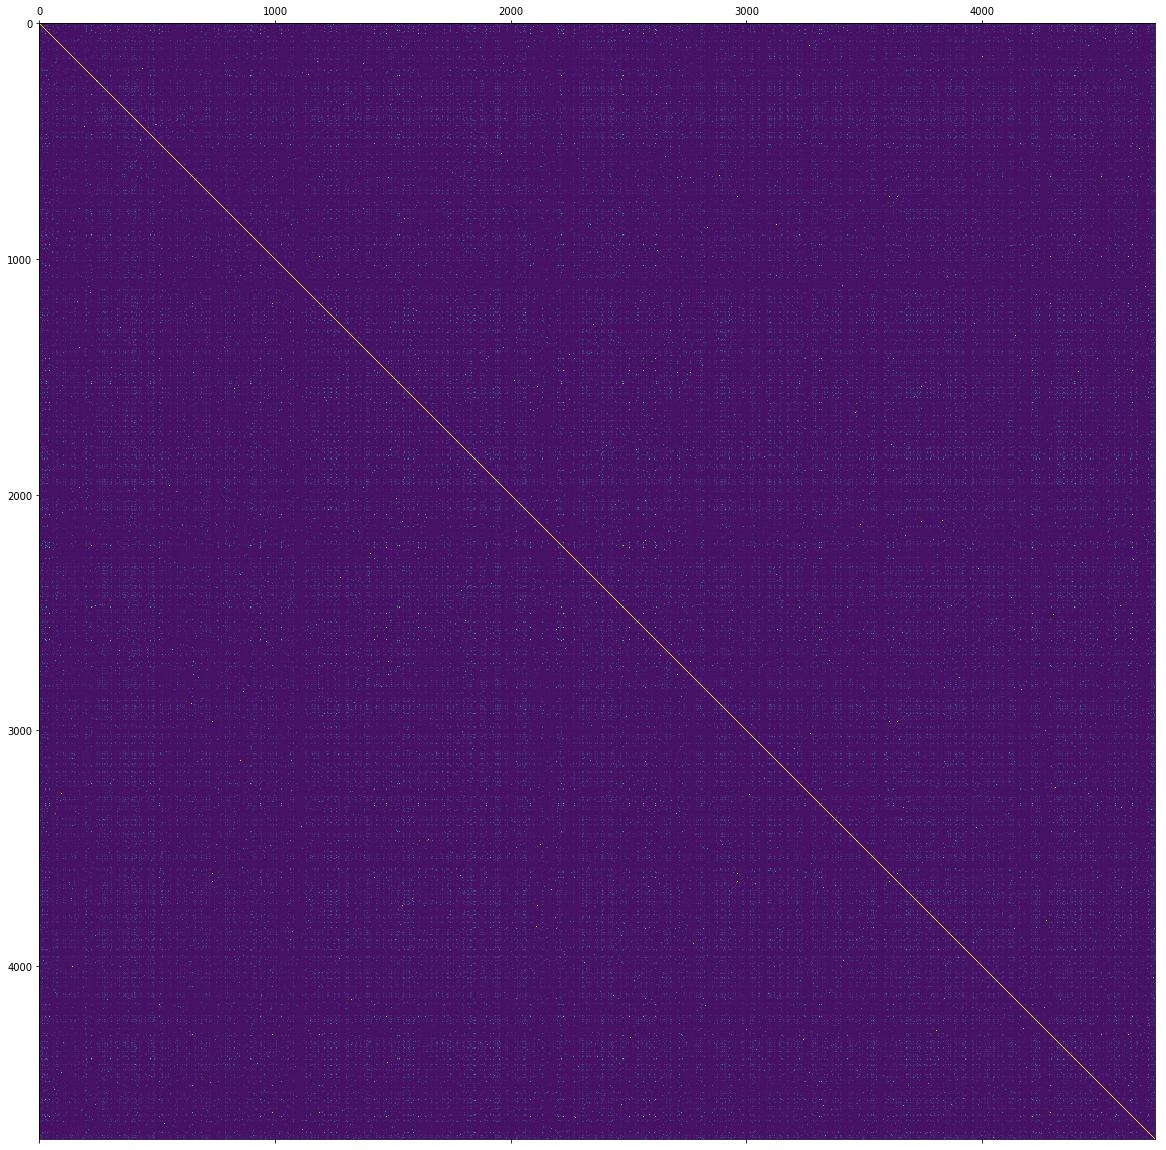

In [18]:
plt.figure(figsize=(20,20))
plt.matshow(corr, fignum=1)

In [19]:
train.shape

(4459, 4737)

In [20]:
col_x = list(train.columns)
col_x.remove('target')
col_x.remove('ID')
col_y = 'target'

In [21]:
X_train, X_val, y_train, y_val = train_test_split(train[col_x], train[col_y], test_size=0.2, random_state=42)

In [22]:
import numpy as np

def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
    
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    assert len(h) == len(y)
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
rand = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=25, n_jobs=-1)

In [25]:
rand.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
pred = rand.predict(X_val)

In [27]:
rmsle(pred, y_val)

1.856088843919298

In [28]:
rmsle(rand.predict(X_train), y_train)

1.7782389874281246

In [29]:
pred = rand.predict(test[col_x])

In [30]:
sample.head()

,ID,target
0,000137c73,5.944923e+06
1,00021489f,5.944923e+06
2,0004d7953,5.944923e+06
3,00056a333,5.944923e+06
4,00056d8eb,5.944923e+06


In [32]:
sample['target'] = pred

In [33]:
sample.to_csv('submission/1_random_forest.csv', index=False)

In [34]:
rand_mod_y = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=25, n_jobs=-1)

In [35]:
rand_mod_y.fit(X_train, np.log10(y_train.values))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [36]:
pred = rand_mod_y.predict(X_train)

In [37]:
rmsle(np.power(pred, 10), y_train.values)

4.0256645113057692

In [39]:
rand_mod_y = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=25, n_jobs=-1)

In [40]:
rand_mod_y.fit(X_train, np.log1p(y_train.values))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
pred = rand_mod_y.predict(X_train)
pred

array([ 14.68140033,  17.03203271,  14.80792508, ...,  14.96095864,
        13.78383339,  14.35088218])

In [43]:
pred_actual = np.expm1(pred)
rmsle(pred_actual, y_train.values)

0.89131607740341368

In [61]:
pred_val = rand_mod_y.predict(X_val)
print(pred_val)

[ 14.40086046  14.6502356   15.00506187  14.42520572  14.43476134
  14.43082493  15.07329988  13.7243973   14.35121716  15.38000456
  14.35101084  13.530333    15.05009972  14.5829277   14.54555305
  14.42353103  15.28166178  15.08455343  15.68743239  15.2536174
  14.67264928  14.30253312  14.42796717  13.5718422   14.42474493
  14.12820893  14.41966601  13.76796236  12.81789471  13.89206335
  15.03250696  14.68690773  14.42287809  14.37883798  14.29640069
  13.53639451  12.30329639  15.32980469  13.67928149  15.93143143
  15.23928205  14.84059487  14.92333495  15.3580098   14.61979939
  14.09806994  14.93058972  14.63199475  13.34710515  14.75449214
  14.70967592  15.16724238  14.97642921  14.29194882  14.35960081
  14.14978158  15.55813423  13.14093762  14.19651444  15.18627251
  14.12118534  14.61767302  14.21083057  14.3325641   14.74277495
  13.67499207  14.25891807  15.01280812  13.79048049  15.70832864
  14.38383375  14.71790783  13.50342136  14.43476134  13.55982089
  14.440599

In [47]:
pred_actual = np.expm1(pred_val)
rmsle(pred_actual, y_val.values)

1.429183824376502

In [62]:
pred = rand_mod_y.predict(test[col_x])

In [63]:
pred

array([ 14.4150021 ,  14.42034513,  14.48011892, ...,  14.0610256 ,
        13.28712103,  14.45414592])

In [64]:
list(filter(lambda x: x < 0, pred))

[]

In [65]:
sample['target'] = np.expm1(pred)

In [66]:
sample.head()

,ID,target
0,000137c73,1.821192e+06
1,00021489f,1.830948e+06
2,0004d7953,1.943728e+06
3,00056a333,3.429001e+06
4,00056d8eb,1.857535e+06


In [67]:
sample.to_csv('submission/2_random_forest_log.csv', index=False)

## LightGBM training

In [44]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
}

In [68]:
y_log_tr = np.log1p(y_train.values)

In [69]:
lgtrain = lgb.Dataset(X_train, label=y_log_tr)
lgval = lgb.Dataset(X_val, label=y_val)
evals_result = {}

In [70]:
model = lgb.train(params, 
                  lgtrain, 
                  1000, 
                  valid_sets=[lgval], 
                  early_stopping_rounds=100, 
                  verbose_eval=200, 
                  evals_result=evals_result)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 9.38321e+06
[400]	valid_0's rmse: 9.38321e+06
[600]	valid_0's rmse: 9.38321e+06
[800]	valid_0's rmse: 9.38321e+06
[1000]	valid_0's rmse: 9.38321e+06
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 9.38321e+06


In [71]:
pred_test_y = model.predict(test[col_x], num_iteration=model.best_iteration)

### Best Features

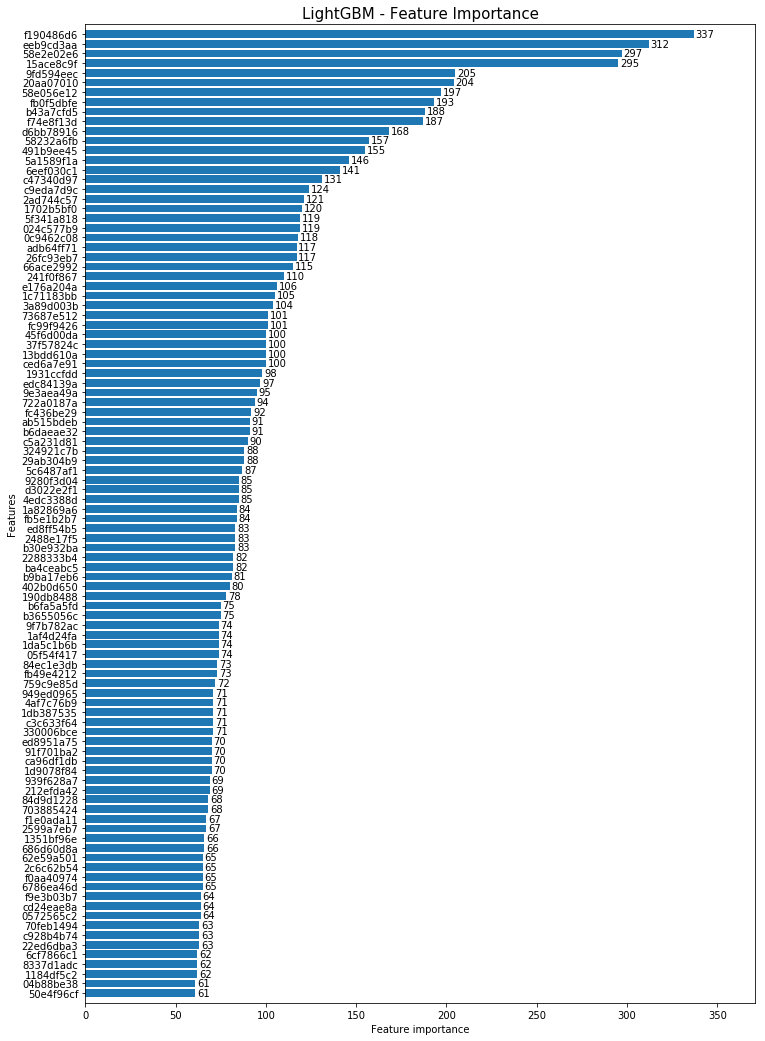

In [85]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [72]:
pred_test_y

array([ 14.39961399,  14.40870998,  14.7348845 , ...,  13.80705509,
        13.34545891,  14.4549703 ])

In [75]:
pred_x = model.predict(X_train)

In [76]:
rmsle(np.expm1(pred_x), y_train.values)

0.85404191444258803

In [77]:
pred_val = model.predict(X_val)

In [79]:
rmsle(np.expm1(pred_val), y_val.values)

1.429426899722904

In [81]:
sample['target'] = np.expm1(pred_test_y)

In [82]:
sample.to_csv('submission/1_lgb_log.csv', index=False)